In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

In [2]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']

db_name = input('DB Name: ')
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + db_name)

DB Name: Historical


Reading the Historical Data

In [3]:
query = "SELECT * FROM PALB777_hour"
hist = pd.read_sql(query, engine)

# EDA & Preprocessing

In [4]:
hist.index = hist['index']
hist.drop('index', axis=1, inplace=True)

In [5]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [6]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,9084.342686,5085.247437,569.734959,3459.848711,3675.624093,4694.237881,5817.094252,5701.875285,6154.639672
std,10095.576421,8944.019925,3508.308840,7782.193918,7986.441379,8816.908037,9064.834853,9137.011880,9668.689192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1762.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17731.146667,11142.077778,0.000000,0.000000,0.000000,761.437778,15609.200000,15453.533333,15790.866667
max,47314.755556,45496.164444,44033.791111,59026.795556,51505.040000,52611.413333,43916.324444,52218.631111,82163.244444


Separate the data

In [7]:
rp72 = hist[['rp7772']].rename({'rp7772':'ff'}, axis=1)
rp73 = hist[['rp7773']].rename({'rp7773':'ff'}, axis=1)
rp74 = hist[['rp7774']].rename({'rp7774':'ff'}, axis=1)
rp75 = hist[['rp7775']].rename({'rp7775':'ff'}, axis=1)
rp76 = hist[['rp7776']].rename({'rp7776':'ff'}, axis=1)
rp77 = hist[['rp7777']].rename({'rp7777':'ff'}, axis=1)
rp78 = hist[['rp7778']].rename({'rp7778':'ff'}, axis=1)
rp79 = hist[['rp7779']].rename({'rp7779':'ff'}, axis=1)
rp782 = hist[['rp7782']].rename({'rp7782':'ff'}, axis=1)

Process the main data (rp7772)

In [8]:
ss = StandardScaler()
ss.fit(rp72) # main data for standardization
time_step = 24*17 # time step for preprocessing

def time_step_prep(data, time_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(data.iloc[i, 0])
    return X, y

In [9]:
n_rp72 = pd.DataFrame(ss.transform(rp72))
X, y = time_step_prep(n_rp72, time_step)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=0.5, shuffle=False)

Add more data to training set

In [10]:
n_rp = [rp73,rp74,rp75,rp76,rp77,rp78,rp79,rp782]

In [11]:
for each in n_rp:
    n_each = pd.DataFrame(ss.transform(each))
    n_X, n_y = time_step_prep(n_each, time_step)
    X_train = np.concatenate([X_train, np.array(n_X)])
    y_train = np.concatenate([y_train, np.array(n_y)])

Convert the data to torch

In [12]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Autoregressive Model

Construct Autoregressive Model

In [13]:
auto_reg = nn.Linear(time_step,1)
optimizer = torch.optim.Adam(auto_reg.parameters(), lr=0.1)
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.1)

In [14]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [15]:
train_loss, test_loss = train_model(
    auto_reg, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test, 
    y_train.reshape(-1,1), 
    y_test.reshape(-1,1),
    scheduler,
    10_000
)

Epoch :0.0005    Train Loss :415.4440612792969    Test Loss :89.7140884399414
Epoch :0.001    Train Loss :198.7190704345703    Test Loss :56.57662582397461
Epoch :0.0015    Train Loss :68.46631622314453    Test Loss :32.09703063964844
Epoch :0.002    Train Loss :9.252939224243164    Test Loss :13.028759956359863
Epoch :0.0025    Train Loss :0.8072957396507263    Test Loss :2.8365442752838135
Epoch :0.003    Train Loss :6.511651992797852    Test Loss :0.7067837715148926
Epoch :0.0035    Train Loss :9.253652572631836    Test Loss :0.8998264074325562
Epoch :0.004    Train Loss :8.140140533447266    Test Loss :1.0911048650741577
Epoch :0.0045    Train Loss :5.843608379364014    Test Loss :1.1524457931518555
Epoch :0.005    Train Loss :3.839536190032959    Test Loss :0.9075949192047119
Epoch :0.0055    Train Loss :2.4367048740386963    Test Loss :0.786246120929718
Epoch :0.006    Train Loss :1.5226727724075317    Test Loss :0.6052626967430115
Epoch :0.0065    Train Loss :0.9353578090667725 

Epoch :0.051    Train Loss :0.14516188204288483    Test Loss :0.3024256229400635
Epoch :0.0515    Train Loss :0.1451033055782318    Test Loss :0.3023032248020172
Epoch :0.052    Train Loss :0.1450471431016922    Test Loss :0.3021858334541321
Epoch :0.0525    Train Loss :0.14499323070049286    Test Loss :0.302073210477829
Epoch :0.053    Train Loss :0.144941508769989    Test Loss :0.30196529626846313
Epoch :0.0535    Train Loss :0.1448918730020523    Test Loss :0.30186185240745544
Epoch :0.054    Train Loss :0.14484423398971558    Test Loss :0.30176278948783875
Epoch :0.0545    Train Loss :0.14479854702949524    Test Loss :0.301667720079422
Epoch :0.055    Train Loss :0.14475470781326294    Test Loss :0.30157670378685
Epoch :0.0555    Train Loss :0.1447126418352127    Test Loss :0.3014894425868988
Epoch :0.056    Train Loss :0.14467228949069977    Test Loss :0.3014059364795685
Epoch :0.0565    Train Loss :0.14463359117507935    Test Loss :0.3013259470462799
Epoch :0.057    Train Loss :0

Epoch :0.1015    Train Loss :0.143768310546875    Test Loss :0.29978179931640625
Epoch :0.102    Train Loss :0.14376766979694366    Test Loss :0.29978281259536743
Epoch :0.1025    Train Loss :0.1437670737504959    Test Loss :0.2997839152812958
Epoch :0.103    Train Loss :0.14376649260520935    Test Loss :0.2997851073741913
Epoch :0.1035    Train Loss :0.14376594126224518    Test Loss :0.299786239862442
Epoch :0.104    Train Loss :0.1437654346227646    Test Loss :0.2997874617576599
Epoch :0.1045    Train Loss :0.1437649428844452    Test Loss :0.29978862404823303
Epoch :0.105    Train Loss :0.143764466047287    Test Loss :0.29978978633880615
Epoch :0.1055    Train Loss :0.14376400411128998    Test Loss :0.29979103803634644
Epoch :0.106    Train Loss :0.14376358687877655    Test Loss :0.29979223012924194
Epoch :0.1065    Train Loss :0.14376318454742432    Test Loss :0.29979345202445984
Epoch :0.107    Train Loss :0.14376279711723328    Test Loss :0.29979467391967773
Epoch :0.1075    Train

Epoch :0.152    Train Loss :0.14375589787960052    Test Loss :0.29985910654067993
Epoch :0.1525    Train Loss :0.14375589787960052    Test Loss :0.29985931515693665
Epoch :0.153    Train Loss :0.14375589787960052    Test Loss :0.29985952377319336
Epoch :0.1535    Train Loss :0.14375589787960052    Test Loss :0.2998597323894501
Epoch :0.154    Train Loss :0.14375589787960052    Test Loss :0.2998599112033844
Epoch :0.1545    Train Loss :0.14375589787960052    Test Loss :0.29986006021499634
Epoch :0.155    Train Loss :0.14375589787960052    Test Loss :0.29986026883125305
Epoch :0.1555    Train Loss :0.14375588297843933    Test Loss :0.299860417842865
Epoch :0.156    Train Loss :0.14375588297843933    Test Loss :0.2998606264591217
Epoch :0.1565    Train Loss :0.14375588297843933    Test Loss :0.29986080527305603
Epoch :0.157    Train Loss :0.14375589787960052    Test Loss :0.29986095428466797
Epoch :0.1575    Train Loss :0.14375588297843933    Test Loss :0.2998611330986023
Epoch :0.158    

Epoch :0.203    Train Loss :0.14375585317611694    Test Loss :0.29986536502838135
Epoch :0.2035    Train Loss :0.14375585317611694    Test Loss :0.29986679553985596
Epoch :0.204    Train Loss :0.14375615119934082    Test Loss :0.29985511302948
Epoch :0.2045    Train Loss :0.14377814531326294    Test Loss :0.29997578263282776
Epoch :0.205    Train Loss :0.1457030326128006    Test Loss :0.30036401748657227
Epoch :0.2055    Train Loss :0.3352411687374115    Test Loss :0.4491101801395416
Epoch :0.206    Train Loss :18.788782119750977    Test Loss :11.82277774810791
Epoch :0.2065    Train Loss :0.4107476770877838    Test Loss :8.212815284729004
Epoch :0.207    Train Loss :26.99427604675293    Test Loss :4.32885217666626
Epoch :0.2075    Train Loss :0.16166643798351288    Test Loss :3.224053382873535
Epoch :0.208    Train Loss :8.239300727844238    Test Loss :0.35832980275154114
Epoch :0.2085    Train Loss :3.566462278366089    Test Loss :1.5012952089309692
Epoch :0.209    Train Loss :0.1698

Epoch :0.254    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.2545    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.255    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.2555    Train Loss :0.14375585317611694    Test Loss :0.29986560344696045
Epoch :0.256    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.2565    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.257    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.2575    Train Loss :0.14375585317611694    Test Loss :0.2998655438423157
Epoch :0.258    Train Loss :0.14375585317611694    Test Loss :0.2998655140399933
Epoch :0.2585    Train Loss :0.14375585317611694    Test Loss :0.2998655438423157
Epoch :0.259    Train Loss :0.14375588297843933    Test Loss :0.2998655438423157
Epoch :0.2595    Train Loss :0.14375588297843933    Test Loss :0.2998655438423157
Epoch :0.26    

Epoch :0.305    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3055    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.306    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3065    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.307    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3075    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.308    Train Loss :0.14375585317611694    Test Loss :0.29986560344696045
Epoch :0.3085    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.309    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3095    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.31    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3105    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.31

Epoch :0.355    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3555    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.356    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3565    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.357    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3575    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.358    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.3585    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.359    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3595    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.36    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.3605    Train Loss :0.14375588297843933    Test Loss :0.29986560344696045
Epoch :0.36

Epoch :0.405    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4055    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.406    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4065    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.407    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4075    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.408    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4085    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.409    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4095    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.41    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.4105    Train Loss :0.14375588297843933    Test Loss :0.29986563324928284
Epoch :0.41

Epoch :0.455    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4555    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.456    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4565    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.457    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.4575    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.458    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.4585    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.459    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.4595    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.46    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.4605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.461    T

Epoch :0.506    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5065    Train Loss :0.14375585317611694    Test Loss :0.2998656928539276
Epoch :0.507    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5075    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.508    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.5085    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.509    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.5095    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.51    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.5105    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.511    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5115    Train Loss :0.14375585317611694    Test Loss :0.29986563324928284
Epoch :0.512    T

Epoch :0.557    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5575    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.558    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5585    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.559    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.56    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.561    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.562    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.5625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.563    Train L

Epoch :0.608    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6085    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.609    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6095    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.61    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6105    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.611    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6115    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.612    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6125    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.613    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.6135    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.614    Train L

Epoch :0.659    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6595    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.66    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.661    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.662    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.663    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.664    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.6645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.665    Train L

Epoch :0.7095    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.71    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7105    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.711    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.7115    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.712    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.7125    Train Loss :0.14375588297843933    Test Loss :0.2998656630516052
Epoch :0.713    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.714    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.715    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7155    Train 

Epoch :0.7605    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.761    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7615    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.762    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.763    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.764    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.765    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.766    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.7665    Train

Epoch :0.8115    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.812    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8125    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.813    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.814    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.815    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.816    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8165    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.817    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8175    Train

Epoch :0.8625    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.863    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8635    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.864    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.865    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.866    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.867    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8675    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.868    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.8685    Train

Epoch :0.9135    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.914    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9145    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.915    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9155    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.916    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9165    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.917    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9175    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.918    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9185    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.919    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9195    Train

Epoch :0.9645    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.965    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9655    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.966    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9665    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.967    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9675    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.968    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9685    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.969    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9695    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.97    Train Loss :0.14375585317611694    Test Loss :0.2998656630516052
Epoch :0.9705    Train 

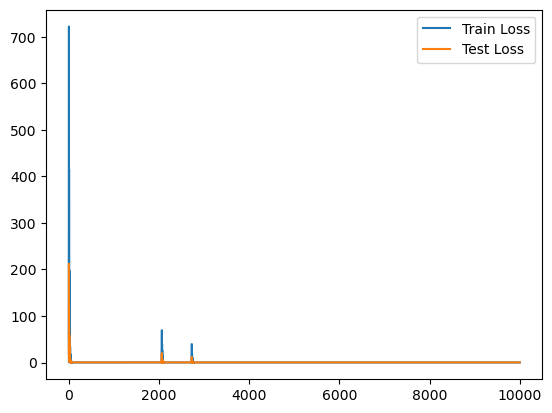

In [16]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [17]:
actual = pd.DataFrame(ss.inverse_transform(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse_transform(auto_reg(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

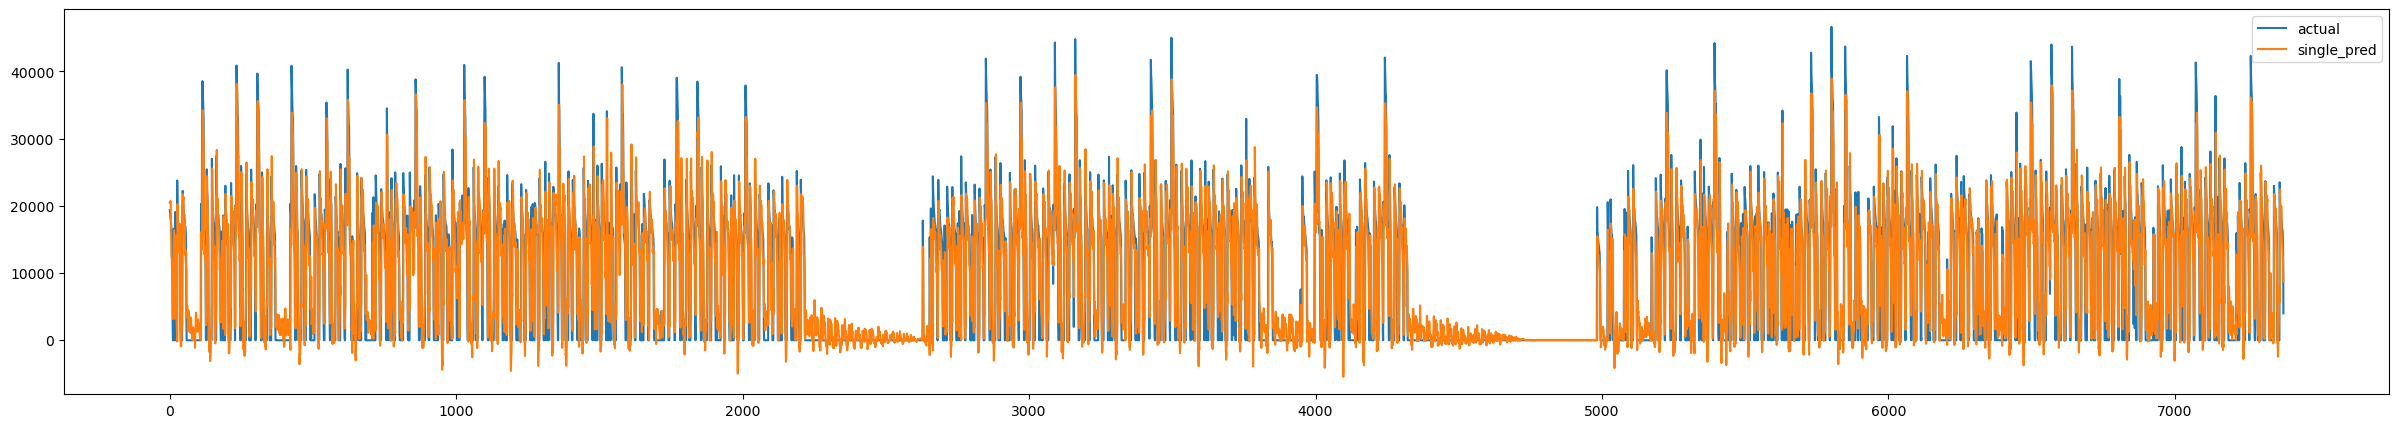

In [18]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred.plot(figsize=(30,5))

In [19]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 5528.14453125
R2: 0.7082307248310643


Multi-step prediction

In [20]:
multi_pred = []
currX = X_test[0]

while len(multi_pred) != len(X_test):
    tensor_pred = auto_reg(currX)
    currX = torch.cat([currX, tensor_pred])
    currX = currX[-time_step:]
    pred = ss.inverse_transform(tensor_pred.detach().numpy().reshape(-1,1))
    multi_pred.append(float(pred))

In [21]:
pred_step = pd.DataFrame({"multi_pred":multi_pred})
pred_step.index = actual_pred.index

<Axes: >

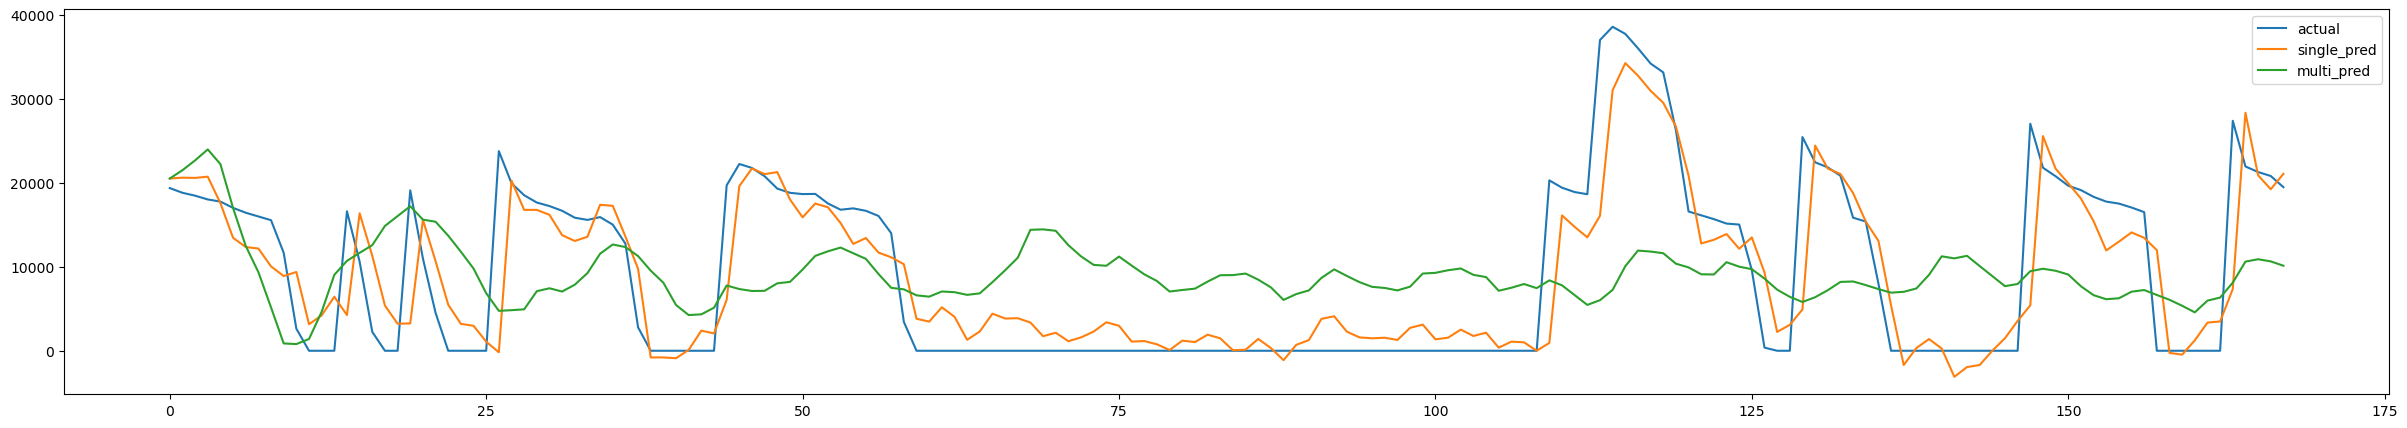

In [22]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].plot(figsize=(30,5))

In [23]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].sum().reset_index()

,index,0
0,actual,1.533315e+06
1,single_pred,1.507399e+06
2,multi_pred,1.533722e+06


# Sampler

In [24]:
class PredSampler():
    def __init__(self, time_step, model, data):
        self.time_step = time_step
        self.model = model
        self.data = data
    def predict(self, numhours_to_predict, date_to_pred, plane_to_test):
        orig_date_to_pred = pd.to_datetime(date_to_pred)
        date_to_pred = pd.to_datetime(date_to_pred)
        input_start_date = date_to_pred - pd.Timedelta(hours=self.time_step)
        input_end_date = date_to_pred - pd.Timedelta(hours=1)
        input_df = self.data[plane_to_test][input_start_date:input_end_date]
        input_X = input_df.values.reshape(-1,1)
        ss = StandardScaler()
        s_input_X = ss.fit_transform(input_X)
        ts_input_X = torch.from_numpy(s_input_X.reshape(-1).astype(np.float32))
        mul_ts_input_X = ts_input_X
        pred_list = []
        
        for i in range(numhours_to_predict):
            ts_pred = self.model(ts_input_X)
            mul_ts_pred = self.model(mul_ts_input_X)
            actual = hist[plane_to_test][date_to_pred]
            single_pred = ss.inverse_transform(ts_pred.detach().numpy().reshape(-1,1))
            multi_pred = ss.inverse_transform(mul_ts_pred.detach().numpy().reshape(-1,1))
            date_to_pred += pd.Timedelta(hours=1)
            
            add_actual = torch.from_numpy(ss.transform(np.array(actual).reshape(-1,1)).reshape(-1).astype(np.float32))
            ts_input_X = torch.cat([ts_input_X, add_actual])[1:]
            mul_ts_input_X = torch.cat([mul_ts_input_X, mul_ts_pred])[1:]
            
            pred_list.append([actual, single_pred[0][0], multi_pred[0][0]])
            
        actual_data = hist[plane_to_test][orig_date_to_pred:orig_date_to_pred + pd.Timedelta(hours=numhours_to_predict-1)]
        pred_df = pd.DataFrame(np.array(pred_list))
        pred_df.columns = ['actual', 'single_pred', 'multi_pred']
        pred_df.index = actual_data.index
        return pred_df

In [25]:
pred_sampler = PredSampler(time_step, auto_reg, hist)

In [27]:
multi_agg = []
for each in hist.iloc[time_step:,0].index:
    result = pred_sampler.predict(24*7, each, 'rp7772')
    multi_agg.append(list(result.sum().values))
    print(each)

2022-01-18 00:00:00
2022-01-18 01:00:00
2022-01-18 02:00:00
2022-01-18 03:00:00
2022-01-18 04:00:00
2022-01-18 05:00:00
2022-01-18 06:00:00
2022-01-18 07:00:00
2022-01-18 08:00:00
2022-01-18 09:00:00
2022-01-18 10:00:00
2022-01-18 11:00:00
2022-01-18 12:00:00
2022-01-18 13:00:00
2022-01-18 14:00:00
2022-01-18 15:00:00
2022-01-18 16:00:00
2022-01-18 17:00:00
2022-01-18 18:00:00
2022-01-18 19:00:00
2022-01-18 20:00:00
2022-01-18 21:00:00
2022-01-18 22:00:00
2022-01-18 23:00:00
2022-01-19 00:00:00
2022-01-19 01:00:00
2022-01-19 02:00:00
2022-01-19 03:00:00
2022-01-19 04:00:00
2022-01-19 05:00:00
2022-01-19 06:00:00
2022-01-19 07:00:00
2022-01-19 08:00:00
2022-01-19 09:00:00
2022-01-19 10:00:00
2022-01-19 11:00:00
2022-01-19 12:00:00
2022-01-19 13:00:00
2022-01-19 14:00:00
2022-01-19 15:00:00
2022-01-19 16:00:00
2022-01-19 17:00:00
2022-01-19 18:00:00
2022-01-19 19:00:00
2022-01-19 20:00:00
2022-01-19 21:00:00
2022-01-19 22:00:00
2022-01-19 23:00:00
2022-01-20 00:00:00
2022-01-20 01:00:00


2022-02-04 03:00:00
2022-02-04 04:00:00
2022-02-04 05:00:00
2022-02-04 06:00:00
2022-02-04 07:00:00
2022-02-04 08:00:00
2022-02-04 09:00:00
2022-02-04 10:00:00
2022-02-04 11:00:00
2022-02-04 12:00:00
2022-02-04 13:00:00
2022-02-04 14:00:00
2022-02-04 15:00:00
2022-02-04 16:00:00
2022-02-04 17:00:00
2022-02-04 18:00:00
2022-02-04 19:00:00
2022-02-04 20:00:00
2022-02-04 21:00:00
2022-02-04 22:00:00
2022-02-04 23:00:00
2022-02-05 00:00:00
2022-02-05 01:00:00
2022-02-05 02:00:00
2022-02-05 03:00:00
2022-02-05 04:00:00
2022-02-05 05:00:00
2022-02-05 06:00:00
2022-02-05 07:00:00
2022-02-05 08:00:00
2022-02-05 09:00:00
2022-02-05 10:00:00
2022-02-05 11:00:00
2022-02-05 12:00:00
2022-02-05 13:00:00
2022-02-05 14:00:00
2022-02-05 15:00:00
2022-02-05 16:00:00
2022-02-05 17:00:00
2022-02-05 18:00:00
2022-02-05 19:00:00
2022-02-05 20:00:00
2022-02-05 21:00:00
2022-02-05 22:00:00
2022-02-05 23:00:00
2022-02-06 00:00:00
2022-02-06 01:00:00
2022-02-06 02:00:00
2022-02-06 03:00:00
2022-02-06 04:00:00


2022-02-21 06:00:00
2022-02-21 07:00:00
2022-02-21 08:00:00
2022-02-21 09:00:00
2022-02-21 10:00:00
2022-02-21 11:00:00
2022-02-21 12:00:00
2022-02-21 13:00:00
2022-02-21 14:00:00
2022-02-21 15:00:00
2022-02-21 16:00:00
2022-02-21 17:00:00
2022-02-21 18:00:00
2022-02-21 19:00:00
2022-02-21 20:00:00
2022-02-21 21:00:00
2022-02-21 22:00:00
2022-02-21 23:00:00
2022-02-22 00:00:00
2022-02-22 01:00:00
2022-02-22 02:00:00
2022-02-22 03:00:00
2022-02-22 04:00:00
2022-02-22 05:00:00
2022-02-22 06:00:00
2022-02-22 07:00:00
2022-02-22 08:00:00
2022-02-22 09:00:00
2022-02-22 10:00:00
2022-02-22 11:00:00
2022-02-22 12:00:00
2022-02-22 13:00:00
2022-02-22 14:00:00
2022-02-22 15:00:00
2022-02-22 16:00:00
2022-02-22 17:00:00
2022-02-22 18:00:00
2022-02-22 19:00:00
2022-02-22 20:00:00
2022-02-22 21:00:00
2022-02-22 22:00:00
2022-02-22 23:00:00
2022-02-23 00:00:00
2022-02-23 01:00:00
2022-02-23 02:00:00
2022-02-23 03:00:00
2022-02-23 04:00:00
2022-02-23 05:00:00
2022-02-23 06:00:00
2022-02-23 07:00:00


2022-03-10 10:00:00
2022-03-10 11:00:00
2022-03-10 12:00:00
2022-03-10 13:00:00
2022-03-10 14:00:00
2022-03-10 15:00:00
2022-03-10 16:00:00
2022-03-10 17:00:00
2022-03-10 18:00:00
2022-03-10 19:00:00
2022-03-10 20:00:00
2022-03-10 21:00:00
2022-03-10 22:00:00
2022-03-10 23:00:00
2022-03-11 00:00:00
2022-03-11 01:00:00
2022-03-11 02:00:00
2022-03-11 03:00:00
2022-03-11 04:00:00
2022-03-11 05:00:00
2022-03-11 06:00:00
2022-03-11 07:00:00
2022-03-11 08:00:00
2022-03-11 09:00:00
2022-03-11 10:00:00
2022-03-11 11:00:00
2022-03-11 12:00:00
2022-03-11 13:00:00
2022-03-11 14:00:00
2022-03-11 15:00:00
2022-03-11 16:00:00
2022-03-11 17:00:00
2022-03-11 18:00:00
2022-03-11 19:00:00
2022-03-11 20:00:00
2022-03-11 21:00:00
2022-03-11 22:00:00
2022-03-11 23:00:00
2022-03-12 00:00:00
2022-03-12 01:00:00
2022-03-12 02:00:00
2022-03-12 03:00:00
2022-03-12 04:00:00
2022-03-12 05:00:00
2022-03-12 06:00:00
2022-03-12 07:00:00
2022-03-12 08:00:00
2022-03-12 09:00:00
2022-03-12 10:00:00
2022-03-12 11:00:00


2022-03-27 14:00:00
2022-03-27 15:00:00
2022-03-27 16:00:00
2022-03-27 17:00:00
2022-03-27 18:00:00
2022-03-27 19:00:00
2022-03-27 20:00:00
2022-03-27 21:00:00
2022-03-27 22:00:00
2022-03-27 23:00:00
2022-03-28 00:00:00
2022-03-28 01:00:00
2022-03-28 02:00:00
2022-03-28 03:00:00
2022-03-28 04:00:00
2022-03-28 05:00:00
2022-03-28 06:00:00
2022-03-28 07:00:00
2022-03-28 08:00:00
2022-03-28 09:00:00
2022-03-28 10:00:00
2022-03-28 11:00:00
2022-03-28 12:00:00
2022-03-28 13:00:00
2022-03-28 14:00:00
2022-03-28 15:00:00
2022-03-28 16:00:00
2022-03-28 17:00:00
2022-03-28 18:00:00
2022-03-28 19:00:00
2022-03-28 20:00:00
2022-03-28 21:00:00
2022-03-28 22:00:00
2022-03-28 23:00:00
2022-03-29 00:00:00
2022-03-29 01:00:00
2022-03-29 02:00:00
2022-03-29 03:00:00
2022-03-29 04:00:00
2022-03-29 05:00:00
2022-03-29 06:00:00
2022-03-29 07:00:00
2022-03-29 08:00:00
2022-03-29 09:00:00
2022-03-29 10:00:00
2022-03-29 11:00:00
2022-03-29 12:00:00
2022-03-29 13:00:00
2022-03-29 14:00:00
2022-03-29 15:00:00


2022-04-13 17:00:00
2022-04-13 18:00:00
2022-04-13 19:00:00
2022-04-13 20:00:00
2022-04-13 21:00:00
2022-04-13 22:00:00
2022-04-13 23:00:00
2022-04-14 00:00:00
2022-04-14 01:00:00
2022-04-14 02:00:00
2022-04-14 03:00:00
2022-04-14 04:00:00
2022-04-14 05:00:00
2022-04-14 06:00:00
2022-04-14 07:00:00
2022-04-14 08:00:00
2022-04-14 09:00:00
2022-04-14 10:00:00
2022-04-14 11:00:00
2022-04-14 12:00:00
2022-04-14 13:00:00
2022-04-14 14:00:00
2022-04-14 15:00:00
2022-04-14 16:00:00
2022-04-14 17:00:00
2022-04-14 18:00:00
2022-04-14 19:00:00
2022-04-14 20:00:00
2022-04-14 21:00:00
2022-04-14 22:00:00
2022-04-14 23:00:00
2022-04-15 00:00:00
2022-04-15 01:00:00
2022-04-15 02:00:00
2022-04-15 03:00:00
2022-04-15 04:00:00
2022-04-15 05:00:00
2022-04-15 06:00:00
2022-04-15 07:00:00
2022-04-15 08:00:00
2022-04-15 09:00:00
2022-04-15 10:00:00
2022-04-15 11:00:00
2022-04-15 12:00:00
2022-04-15 13:00:00
2022-04-15 14:00:00
2022-04-15 15:00:00
2022-04-15 16:00:00
2022-04-15 17:00:00
2022-04-15 18:00:00


2022-04-30 19:00:00
2022-04-30 20:00:00
2022-04-30 21:00:00
2022-04-30 22:00:00
2022-04-30 23:00:00
2022-05-01 00:00:00
2022-05-01 01:00:00
2022-05-01 02:00:00
2022-05-01 03:00:00
2022-05-01 04:00:00
2022-05-01 05:00:00
2022-05-01 06:00:00
2022-05-01 07:00:00
2022-05-01 08:00:00
2022-05-01 09:00:00
2022-05-01 10:00:00
2022-05-01 11:00:00
2022-05-01 12:00:00
2022-05-01 13:00:00
2022-05-01 14:00:00
2022-05-01 15:00:00
2022-05-01 16:00:00
2022-05-01 17:00:00
2022-05-01 18:00:00
2022-05-01 19:00:00
2022-05-01 20:00:00
2022-05-01 21:00:00
2022-05-01 22:00:00
2022-05-01 23:00:00
2022-05-02 00:00:00
2022-05-02 01:00:00
2022-05-02 02:00:00
2022-05-02 03:00:00
2022-05-02 04:00:00
2022-05-02 05:00:00
2022-05-02 06:00:00
2022-05-02 07:00:00
2022-05-02 08:00:00
2022-05-02 09:00:00
2022-05-02 10:00:00
2022-05-02 11:00:00
2022-05-02 12:00:00
2022-05-02 13:00:00
2022-05-02 14:00:00
2022-05-02 15:00:00
2022-05-02 16:00:00
2022-05-02 17:00:00
2022-05-02 18:00:00
2022-05-02 19:00:00
2022-05-02 20:00:00


2022-05-17 22:00:00
2022-05-17 23:00:00
2022-05-18 00:00:00
2022-05-18 01:00:00
2022-05-18 02:00:00
2022-05-18 03:00:00
2022-05-18 04:00:00
2022-05-18 05:00:00
2022-05-18 06:00:00
2022-05-18 07:00:00
2022-05-18 08:00:00
2022-05-18 09:00:00
2022-05-18 10:00:00
2022-05-18 11:00:00
2022-05-18 12:00:00
2022-05-18 13:00:00
2022-05-18 14:00:00
2022-05-18 15:00:00
2022-05-18 16:00:00
2022-05-18 17:00:00
2022-05-18 18:00:00
2022-05-18 19:00:00
2022-05-18 20:00:00
2022-05-18 21:00:00
2022-05-18 22:00:00
2022-05-18 23:00:00
2022-05-19 00:00:00
2022-05-19 01:00:00
2022-05-19 02:00:00
2022-05-19 03:00:00
2022-05-19 04:00:00
2022-05-19 05:00:00
2022-05-19 06:00:00
2022-05-19 07:00:00
2022-05-19 08:00:00
2022-05-19 09:00:00
2022-05-19 10:00:00
2022-05-19 11:00:00
2022-05-19 12:00:00
2022-05-19 13:00:00
2022-05-19 14:00:00
2022-05-19 15:00:00
2022-05-19 16:00:00
2022-05-19 17:00:00
2022-05-19 18:00:00
2022-05-19 19:00:00
2022-05-19 20:00:00
2022-05-19 21:00:00
2022-05-19 22:00:00
2022-05-19 23:00:00


2022-06-04 01:00:00
2022-06-04 02:00:00
2022-06-04 03:00:00
2022-06-04 04:00:00
2022-06-04 05:00:00
2022-06-04 06:00:00
2022-06-04 07:00:00
2022-06-04 08:00:00
2022-06-04 09:00:00
2022-06-04 10:00:00
2022-06-04 11:00:00
2022-06-04 12:00:00
2022-06-04 13:00:00
2022-06-04 14:00:00
2022-06-04 15:00:00
2022-06-04 16:00:00
2022-06-04 17:00:00
2022-06-04 18:00:00
2022-06-04 19:00:00
2022-06-04 20:00:00
2022-06-04 21:00:00
2022-06-04 22:00:00
2022-06-04 23:00:00
2022-06-05 00:00:00
2022-06-05 01:00:00
2022-06-05 02:00:00
2022-06-05 03:00:00
2022-06-05 04:00:00
2022-06-05 05:00:00
2022-06-05 06:00:00
2022-06-05 07:00:00
2022-06-05 08:00:00
2022-06-05 09:00:00
2022-06-05 10:00:00
2022-06-05 11:00:00
2022-06-05 12:00:00
2022-06-05 13:00:00
2022-06-05 14:00:00
2022-06-05 15:00:00
2022-06-05 16:00:00
2022-06-05 17:00:00
2022-06-05 18:00:00
2022-06-05 19:00:00
2022-06-05 20:00:00
2022-06-05 21:00:00
2022-06-05 22:00:00
2022-06-05 23:00:00
2022-06-06 00:00:00
2022-06-06 01:00:00
2022-06-06 02:00:00


2022-06-21 05:00:00
2022-06-21 06:00:00
2022-06-21 07:00:00
2022-06-21 08:00:00
2022-06-21 09:00:00
2022-06-21 10:00:00
2022-06-21 11:00:00
2022-06-21 12:00:00
2022-06-21 13:00:00
2022-06-21 14:00:00
2022-06-21 15:00:00
2022-06-21 16:00:00
2022-06-21 17:00:00
2022-06-21 18:00:00
2022-06-21 19:00:00
2022-06-21 20:00:00
2022-06-21 21:00:00
2022-06-21 22:00:00
2022-06-21 23:00:00
2022-06-22 00:00:00
2022-06-22 01:00:00
2022-06-22 02:00:00
2022-06-22 03:00:00
2022-06-22 04:00:00
2022-06-22 05:00:00
2022-06-22 06:00:00
2022-06-22 07:00:00
2022-06-22 08:00:00
2022-06-22 09:00:00
2022-06-22 10:00:00
2022-06-22 11:00:00
2022-06-22 12:00:00
2022-06-22 13:00:00
2022-06-22 14:00:00
2022-06-22 15:00:00
2022-06-22 16:00:00
2022-06-22 17:00:00
2022-06-22 18:00:00
2022-06-22 19:00:00
2022-06-22 20:00:00
2022-06-22 21:00:00
2022-06-22 22:00:00
2022-06-22 23:00:00
2022-06-23 00:00:00
2022-06-23 01:00:00
2022-06-23 02:00:00
2022-06-23 03:00:00
2022-06-23 04:00:00
2022-06-23 05:00:00
2022-06-23 06:00:00


2022-07-08 08:00:00
2022-07-08 09:00:00
2022-07-08 10:00:00
2022-07-08 11:00:00
2022-07-08 12:00:00
2022-07-08 13:00:00
2022-07-08 14:00:00
2022-07-08 15:00:00
2022-07-08 16:00:00
2022-07-08 17:00:00
2022-07-08 18:00:00
2022-07-08 19:00:00
2022-07-08 20:00:00
2022-07-08 21:00:00
2022-07-08 22:00:00
2022-07-08 23:00:00
2022-07-09 00:00:00
2022-07-09 01:00:00
2022-07-09 02:00:00
2022-07-09 03:00:00
2022-07-09 04:00:00
2022-07-09 05:00:00
2022-07-09 06:00:00
2022-07-09 07:00:00
2022-07-09 08:00:00
2022-07-09 09:00:00
2022-07-09 10:00:00
2022-07-09 11:00:00
2022-07-09 12:00:00
2022-07-09 13:00:00
2022-07-09 14:00:00
2022-07-09 15:00:00
2022-07-09 16:00:00
2022-07-09 17:00:00
2022-07-09 18:00:00
2022-07-09 19:00:00
2022-07-09 20:00:00
2022-07-09 21:00:00
2022-07-09 22:00:00
2022-07-09 23:00:00
2022-07-10 00:00:00
2022-07-10 01:00:00
2022-07-10 02:00:00
2022-07-10 03:00:00
2022-07-10 04:00:00
2022-07-10 05:00:00
2022-07-10 06:00:00
2022-07-10 07:00:00
2022-07-10 08:00:00
2022-07-10 09:00:00


2022-07-25 10:00:00
2022-07-25 11:00:00
2022-07-25 12:00:00
2022-07-25 13:00:00
2022-07-25 14:00:00
2022-07-25 15:00:00
2022-07-25 16:00:00
2022-07-25 17:00:00
2022-07-25 18:00:00
2022-07-25 19:00:00
2022-07-25 20:00:00
2022-07-25 21:00:00
2022-07-25 22:00:00
2022-07-25 23:00:00
2022-07-26 00:00:00
2022-07-26 01:00:00
2022-07-26 02:00:00
2022-07-26 03:00:00
2022-07-26 04:00:00
2022-07-26 05:00:00
2022-07-26 06:00:00
2022-07-26 07:00:00
2022-07-26 08:00:00
2022-07-26 09:00:00
2022-07-26 10:00:00
2022-07-26 11:00:00
2022-07-26 12:00:00
2022-07-26 13:00:00
2022-07-26 14:00:00
2022-07-26 15:00:00
2022-07-26 16:00:00
2022-07-26 17:00:00
2022-07-26 18:00:00
2022-07-26 19:00:00
2022-07-26 20:00:00
2022-07-26 21:00:00
2022-07-26 22:00:00
2022-07-26 23:00:00
2022-07-27 00:00:00
2022-07-27 01:00:00
2022-07-27 02:00:00
2022-07-27 03:00:00
2022-07-27 04:00:00
2022-07-27 05:00:00
2022-07-27 06:00:00
2022-07-27 07:00:00
2022-07-27 08:00:00
2022-07-27 09:00:00
2022-07-27 10:00:00
2022-07-27 11:00:00


2022-08-11 12:00:00
2022-08-11 13:00:00
2022-08-11 14:00:00
2022-08-11 15:00:00
2022-08-11 16:00:00
2022-08-11 17:00:00
2022-08-11 18:00:00
2022-08-11 19:00:00
2022-08-11 20:00:00
2022-08-11 21:00:00
2022-08-11 22:00:00
2022-08-11 23:00:00
2022-08-12 00:00:00
2022-08-12 01:00:00
2022-08-12 02:00:00
2022-08-12 03:00:00
2022-08-12 04:00:00
2022-08-12 05:00:00
2022-08-12 06:00:00
2022-08-12 07:00:00
2022-08-12 08:00:00
2022-08-12 09:00:00
2022-08-12 10:00:00
2022-08-12 11:00:00
2022-08-12 12:00:00
2022-08-12 13:00:00
2022-08-12 14:00:00
2022-08-12 15:00:00
2022-08-12 16:00:00
2022-08-12 17:00:00
2022-08-12 18:00:00
2022-08-12 19:00:00
2022-08-12 20:00:00
2022-08-12 21:00:00
2022-08-12 22:00:00
2022-08-12 23:00:00
2022-08-13 00:00:00
2022-08-13 01:00:00
2022-08-13 02:00:00
2022-08-13 03:00:00
2022-08-13 04:00:00
2022-08-13 05:00:00
2022-08-13 06:00:00
2022-08-13 07:00:00
2022-08-13 08:00:00
2022-08-13 09:00:00
2022-08-13 10:00:00
2022-08-13 11:00:00
2022-08-13 12:00:00
2022-08-13 13:00:00


2022-08-28 14:00:00
2022-08-28 15:00:00
2022-08-28 16:00:00
2022-08-28 17:00:00
2022-08-28 18:00:00
2022-08-28 19:00:00
2022-08-28 20:00:00
2022-08-28 21:00:00
2022-08-28 22:00:00
2022-08-28 23:00:00
2022-08-29 00:00:00
2022-08-29 01:00:00
2022-08-29 02:00:00
2022-08-29 03:00:00
2022-08-29 04:00:00
2022-08-29 05:00:00
2022-08-29 06:00:00
2022-08-29 07:00:00
2022-08-29 08:00:00
2022-08-29 09:00:00
2022-08-29 10:00:00
2022-08-29 11:00:00
2022-08-29 12:00:00
2022-08-29 13:00:00
2022-08-29 14:00:00
2022-08-29 15:00:00
2022-08-29 16:00:00
2022-08-29 17:00:00
2022-08-29 18:00:00
2022-08-29 19:00:00
2022-08-29 20:00:00
2022-08-29 21:00:00
2022-08-29 22:00:00
2022-08-29 23:00:00
2022-08-30 00:00:00
2022-08-30 01:00:00
2022-08-30 02:00:00
2022-08-30 03:00:00
2022-08-30 04:00:00
2022-08-30 05:00:00
2022-08-30 06:00:00
2022-08-30 07:00:00
2022-08-30 08:00:00
2022-08-30 09:00:00
2022-08-30 10:00:00
2022-08-30 11:00:00
2022-08-30 12:00:00
2022-08-30 13:00:00
2022-08-30 14:00:00
2022-08-30 15:00:00


2022-09-14 16:00:00
2022-09-14 17:00:00
2022-09-14 18:00:00
2022-09-14 19:00:00
2022-09-14 20:00:00
2022-09-14 21:00:00
2022-09-14 22:00:00
2022-09-14 23:00:00
2022-09-15 00:00:00
2022-09-15 01:00:00
2022-09-15 02:00:00
2022-09-15 03:00:00
2022-09-15 04:00:00
2022-09-15 05:00:00
2022-09-15 06:00:00
2022-09-15 07:00:00
2022-09-15 08:00:00
2022-09-15 09:00:00
2022-09-15 10:00:00
2022-09-15 11:00:00
2022-09-15 12:00:00
2022-09-15 13:00:00
2022-09-15 14:00:00
2022-09-15 15:00:00
2022-09-15 16:00:00
2022-09-15 17:00:00
2022-09-15 18:00:00
2022-09-15 19:00:00
2022-09-15 20:00:00
2022-09-15 21:00:00
2022-09-15 22:00:00
2022-09-15 23:00:00
2022-09-16 00:00:00
2022-09-16 01:00:00
2022-09-16 02:00:00
2022-09-16 03:00:00
2022-09-16 04:00:00
2022-09-16 05:00:00
2022-09-16 06:00:00
2022-09-16 07:00:00
2022-09-16 08:00:00
2022-09-16 09:00:00
2022-09-16 10:00:00
2022-09-16 11:00:00
2022-09-16 12:00:00
2022-09-16 13:00:00
2022-09-16 14:00:00
2022-09-16 15:00:00
2022-09-16 16:00:00
2022-09-16 17:00:00


2022-10-01 19:00:00
2022-10-01 20:00:00
2022-10-01 21:00:00
2022-10-01 22:00:00
2022-10-01 23:00:00
2022-10-02 00:00:00
2022-10-02 01:00:00
2022-10-02 02:00:00
2022-10-02 03:00:00
2022-10-02 04:00:00
2022-10-02 05:00:00
2022-10-02 06:00:00
2022-10-02 07:00:00
2022-10-02 08:00:00
2022-10-02 09:00:00
2022-10-02 10:00:00
2022-10-02 11:00:00
2022-10-02 12:00:00
2022-10-02 13:00:00
2022-10-02 14:00:00
2022-10-02 15:00:00
2022-10-02 16:00:00
2022-10-02 17:00:00
2022-10-02 18:00:00
2022-10-02 19:00:00
2022-10-02 20:00:00
2022-10-02 21:00:00
2022-10-02 22:00:00
2022-10-02 23:00:00
2022-10-03 00:00:00
2022-10-03 01:00:00
2022-10-03 02:00:00
2022-10-03 03:00:00
2022-10-03 04:00:00
2022-10-03 05:00:00
2022-10-03 06:00:00
2022-10-03 07:00:00
2022-10-03 08:00:00
2022-10-03 09:00:00
2022-10-03 10:00:00
2022-10-03 11:00:00
2022-10-03 12:00:00
2022-10-03 13:00:00
2022-10-03 14:00:00
2022-10-03 15:00:00
2022-10-03 16:00:00
2022-10-03 17:00:00
2022-10-03 18:00:00
2022-10-03 19:00:00
2022-10-03 20:00:00


2022-10-18 23:00:00
2022-10-19 00:00:00
2022-10-19 01:00:00
2022-10-19 02:00:00
2022-10-19 03:00:00
2022-10-19 04:00:00
2022-10-19 05:00:00
2022-10-19 06:00:00
2022-10-19 07:00:00
2022-10-19 08:00:00
2022-10-19 09:00:00
2022-10-19 10:00:00
2022-10-19 11:00:00
2022-10-19 12:00:00
2022-10-19 13:00:00
2022-10-19 14:00:00
2022-10-19 15:00:00
2022-10-19 16:00:00
2022-10-19 17:00:00
2022-10-19 18:00:00
2022-10-19 19:00:00
2022-10-19 20:00:00
2022-10-19 21:00:00
2022-10-19 22:00:00
2022-10-19 23:00:00
2022-10-20 00:00:00
2022-10-20 01:00:00
2022-10-20 02:00:00
2022-10-20 03:00:00
2022-10-20 04:00:00
2022-10-20 05:00:00
2022-10-20 06:00:00
2022-10-20 07:00:00
2022-10-20 08:00:00
2022-10-20 09:00:00
2022-10-20 10:00:00
2022-10-20 11:00:00
2022-10-20 12:00:00
2022-10-20 13:00:00
2022-10-20 14:00:00
2022-10-20 15:00:00
2022-10-20 16:00:00
2022-10-20 17:00:00
2022-10-20 18:00:00
2022-10-20 19:00:00
2022-10-20 20:00:00
2022-10-20 21:00:00
2022-10-20 22:00:00
2022-10-20 23:00:00
2022-10-21 00:00:00


2022-11-05 01:00:00
2022-11-05 02:00:00
2022-11-05 03:00:00
2022-11-05 04:00:00
2022-11-05 05:00:00
2022-11-05 06:00:00
2022-11-05 07:00:00
2022-11-05 08:00:00
2022-11-05 09:00:00
2022-11-05 10:00:00
2022-11-05 11:00:00
2022-11-05 12:00:00
2022-11-05 13:00:00
2022-11-05 14:00:00
2022-11-05 15:00:00
2022-11-05 16:00:00
2022-11-05 17:00:00
2022-11-05 18:00:00
2022-11-05 19:00:00
2022-11-05 20:00:00
2022-11-05 21:00:00
2022-11-05 22:00:00
2022-11-05 23:00:00
2022-11-06 00:00:00
2022-11-06 01:00:00
2022-11-06 02:00:00
2022-11-06 03:00:00
2022-11-06 04:00:00
2022-11-06 05:00:00
2022-11-06 06:00:00
2022-11-06 07:00:00
2022-11-06 08:00:00
2022-11-06 09:00:00
2022-11-06 10:00:00
2022-11-06 11:00:00
2022-11-06 12:00:00
2022-11-06 13:00:00
2022-11-06 14:00:00
2022-11-06 15:00:00
2022-11-06 16:00:00
2022-11-06 17:00:00
2022-11-06 18:00:00
2022-11-06 19:00:00
2022-11-06 20:00:00
2022-11-06 21:00:00
2022-11-06 22:00:00
2022-11-06 23:00:00
2022-11-07 00:00:00
2022-11-07 01:00:00
2022-11-07 02:00:00


2022-11-22 04:00:00
2022-11-22 05:00:00
2022-11-22 06:00:00
2022-11-22 07:00:00
2022-11-22 08:00:00
2022-11-22 09:00:00
2022-11-22 10:00:00
2022-11-22 11:00:00
2022-11-22 12:00:00
2022-11-22 13:00:00
2022-11-22 14:00:00
2022-11-22 15:00:00
2022-11-22 16:00:00
2022-11-22 17:00:00
2022-11-22 18:00:00
2022-11-22 19:00:00
2022-11-22 20:00:00
2022-11-22 21:00:00
2022-11-22 22:00:00
2022-11-22 23:00:00
2022-11-23 00:00:00
2022-11-23 01:00:00
2022-11-23 02:00:00
2022-11-23 03:00:00
2022-11-23 04:00:00
2022-11-23 05:00:00
2022-11-23 06:00:00
2022-11-23 07:00:00
2022-11-23 08:00:00
2022-11-23 09:00:00
2022-11-23 10:00:00
2022-11-23 11:00:00
2022-11-23 12:00:00
2022-11-23 13:00:00
2022-11-23 14:00:00
2022-11-23 15:00:00
2022-11-23 16:00:00
2022-11-23 17:00:00
2022-11-23 18:00:00
2022-11-23 19:00:00
2022-11-23 20:00:00
2022-11-23 21:00:00
2022-11-23 22:00:00
2022-11-23 23:00:00
2022-11-24 00:00:00
2022-11-24 01:00:00
2022-11-24 02:00:00
2022-11-24 03:00:00
2022-11-24 04:00:00
2022-11-24 05:00:00


2022-12-09 07:00:00
2022-12-09 08:00:00
2022-12-09 09:00:00
2022-12-09 10:00:00
2022-12-09 11:00:00
2022-12-09 12:00:00
2022-12-09 13:00:00
2022-12-09 14:00:00
2022-12-09 15:00:00
2022-12-09 16:00:00
2022-12-09 17:00:00
2022-12-09 18:00:00
2022-12-09 19:00:00
2022-12-09 20:00:00
2022-12-09 21:00:00
2022-12-09 22:00:00
2022-12-09 23:00:00
2022-12-10 00:00:00
2022-12-10 01:00:00
2022-12-10 02:00:00
2022-12-10 03:00:00
2022-12-10 04:00:00
2022-12-10 05:00:00
2022-12-10 06:00:00
2022-12-10 07:00:00
2022-12-10 08:00:00
2022-12-10 09:00:00
2022-12-10 10:00:00
2022-12-10 11:00:00
2022-12-10 12:00:00
2022-12-10 13:00:00
2022-12-10 14:00:00
2022-12-10 15:00:00
2022-12-10 16:00:00
2022-12-10 17:00:00
2022-12-10 18:00:00
2022-12-10 19:00:00
2022-12-10 20:00:00
2022-12-10 21:00:00
2022-12-10 22:00:00
2022-12-10 23:00:00
2022-12-11 00:00:00
2022-12-11 01:00:00
2022-12-11 02:00:00
2022-12-11 03:00:00
2022-12-11 04:00:00
2022-12-11 05:00:00
2022-12-11 06:00:00
2022-12-11 07:00:00
2022-12-11 08:00:00


2022-12-26 11:00:00
2022-12-26 12:00:00
2022-12-26 13:00:00
2022-12-26 14:00:00
2022-12-26 15:00:00
2022-12-26 16:00:00
2022-12-26 17:00:00
2022-12-26 18:00:00
2022-12-26 19:00:00
2022-12-26 20:00:00
2022-12-26 21:00:00
2022-12-26 22:00:00
2022-12-26 23:00:00
2022-12-27 00:00:00
2022-12-27 01:00:00
2022-12-27 02:00:00
2022-12-27 03:00:00
2022-12-27 04:00:00
2022-12-27 05:00:00
2022-12-27 06:00:00
2022-12-27 07:00:00
2022-12-27 08:00:00
2022-12-27 09:00:00
2022-12-27 10:00:00
2022-12-27 11:00:00
2022-12-27 12:00:00
2022-12-27 13:00:00
2022-12-27 14:00:00
2022-12-27 15:00:00
2022-12-27 16:00:00
2022-12-27 17:00:00
2022-12-27 18:00:00
2022-12-27 19:00:00
2022-12-27 20:00:00
2022-12-27 21:00:00
2022-12-27 22:00:00
2022-12-27 23:00:00
2022-12-28 00:00:00
2022-12-28 01:00:00
2022-12-28 02:00:00
2022-12-28 03:00:00
2022-12-28 04:00:00
2022-12-28 05:00:00
2022-12-28 06:00:00
2022-12-28 07:00:00
2022-12-28 08:00:00
2022-12-28 09:00:00
2022-12-28 10:00:00
2022-12-28 11:00:00
2022-12-28 12:00:00


2023-01-12 14:00:00
2023-01-12 15:00:00
2023-01-12 16:00:00
2023-01-12 17:00:00
2023-01-12 18:00:00
2023-01-12 19:00:00
2023-01-12 20:00:00
2023-01-12 21:00:00
2023-01-12 22:00:00
2023-01-12 23:00:00
2023-01-13 00:00:00
2023-01-13 01:00:00
2023-01-13 02:00:00
2023-01-13 03:00:00
2023-01-13 04:00:00
2023-01-13 05:00:00
2023-01-13 06:00:00
2023-01-13 07:00:00
2023-01-13 08:00:00
2023-01-13 09:00:00
2023-01-13 10:00:00
2023-01-13 11:00:00
2023-01-13 12:00:00
2023-01-13 13:00:00
2023-01-13 14:00:00
2023-01-13 15:00:00
2023-01-13 16:00:00
2023-01-13 17:00:00
2023-01-13 18:00:00
2023-01-13 19:00:00
2023-01-13 20:00:00
2023-01-13 21:00:00
2023-01-13 22:00:00
2023-01-13 23:00:00
2023-01-14 00:00:00
2023-01-14 01:00:00
2023-01-14 02:00:00
2023-01-14 03:00:00
2023-01-14 04:00:00
2023-01-14 05:00:00
2023-01-14 06:00:00
2023-01-14 07:00:00
2023-01-14 08:00:00
2023-01-14 09:00:00
2023-01-14 10:00:00
2023-01-14 11:00:00
2023-01-14 12:00:00
2023-01-14 13:00:00
2023-01-14 14:00:00
2023-01-14 15:00:00


2023-01-29 17:00:00
2023-01-29 18:00:00
2023-01-29 19:00:00
2023-01-29 20:00:00
2023-01-29 21:00:00
2023-01-29 22:00:00
2023-01-29 23:00:00
2023-01-30 00:00:00
2023-01-30 01:00:00
2023-01-30 02:00:00
2023-01-30 03:00:00
2023-01-30 04:00:00
2023-01-30 05:00:00
2023-01-30 06:00:00
2023-01-30 07:00:00
2023-01-30 08:00:00
2023-01-30 09:00:00
2023-01-30 10:00:00
2023-01-30 11:00:00
2023-01-30 12:00:00
2023-01-30 13:00:00
2023-01-30 14:00:00
2023-01-30 15:00:00
2023-01-30 16:00:00
2023-01-30 17:00:00
2023-01-30 18:00:00
2023-01-30 19:00:00
2023-01-30 20:00:00
2023-01-30 21:00:00
2023-01-30 22:00:00
2023-01-30 23:00:00
2023-01-31 00:00:00
2023-01-31 01:00:00
2023-01-31 02:00:00
2023-01-31 03:00:00
2023-01-31 04:00:00
2023-01-31 05:00:00
2023-01-31 06:00:00
2023-01-31 07:00:00
2023-01-31 08:00:00
2023-01-31 09:00:00
2023-01-31 10:00:00
2023-01-31 11:00:00
2023-01-31 12:00:00
2023-01-31 13:00:00
2023-01-31 14:00:00
2023-01-31 15:00:00
2023-01-31 16:00:00
2023-01-31 17:00:00
2023-01-31 18:00:00


2023-02-15 20:00:00
2023-02-15 21:00:00
2023-02-15 22:00:00
2023-02-15 23:00:00
2023-02-16 00:00:00
2023-02-16 01:00:00
2023-02-16 02:00:00
2023-02-16 03:00:00
2023-02-16 04:00:00
2023-02-16 05:00:00
2023-02-16 06:00:00
2023-02-16 07:00:00
2023-02-16 08:00:00
2023-02-16 09:00:00
2023-02-16 10:00:00
2023-02-16 11:00:00
2023-02-16 12:00:00
2023-02-16 13:00:00
2023-02-16 14:00:00
2023-02-16 15:00:00
2023-02-16 16:00:00
2023-02-16 17:00:00
2023-02-16 18:00:00
2023-02-16 19:00:00
2023-02-16 20:00:00
2023-02-16 21:00:00
2023-02-16 22:00:00
2023-02-16 23:00:00
2023-02-17 00:00:00
2023-02-17 01:00:00
2023-02-17 02:00:00
2023-02-17 03:00:00
2023-02-17 04:00:00
2023-02-17 05:00:00
2023-02-17 06:00:00
2023-02-17 07:00:00
2023-02-17 08:00:00
2023-02-17 09:00:00
2023-02-17 10:00:00
2023-02-17 11:00:00
2023-02-17 12:00:00
2023-02-17 13:00:00
2023-02-17 14:00:00
2023-02-17 15:00:00
2023-02-17 16:00:00
2023-02-17 17:00:00
2023-02-17 18:00:00
2023-02-17 19:00:00
2023-02-17 20:00:00
2023-02-17 21:00:00


2023-03-04 22:00:00
2023-03-04 23:00:00
2023-03-05 00:00:00
2023-03-05 01:00:00
2023-03-05 02:00:00
2023-03-05 03:00:00
2023-03-05 04:00:00
2023-03-05 05:00:00
2023-03-05 06:00:00
2023-03-05 07:00:00
2023-03-05 08:00:00
2023-03-05 09:00:00
2023-03-05 10:00:00
2023-03-05 11:00:00
2023-03-05 12:00:00
2023-03-05 13:00:00
2023-03-05 14:00:00
2023-03-05 15:00:00
2023-03-05 16:00:00
2023-03-05 17:00:00
2023-03-05 18:00:00
2023-03-05 19:00:00
2023-03-05 20:00:00
2023-03-05 21:00:00
2023-03-05 22:00:00
2023-03-05 23:00:00
2023-03-06 00:00:00
2023-03-06 01:00:00
2023-03-06 02:00:00
2023-03-06 03:00:00
2023-03-06 04:00:00
2023-03-06 05:00:00
2023-03-06 06:00:00
2023-03-06 07:00:00
2023-03-06 08:00:00
2023-03-06 09:00:00
2023-03-06 10:00:00
2023-03-06 11:00:00
2023-03-06 12:00:00
2023-03-06 13:00:00
2023-03-06 14:00:00
2023-03-06 15:00:00
2023-03-06 16:00:00
2023-03-06 17:00:00
2023-03-06 18:00:00
2023-03-06 19:00:00
2023-03-06 20:00:00
2023-03-06 21:00:00
2023-03-06 22:00:00
2023-03-06 23:00:00


2023-03-22 01:00:00
2023-03-22 02:00:00
2023-03-22 03:00:00
2023-03-22 04:00:00
2023-03-22 05:00:00
2023-03-22 06:00:00
2023-03-22 07:00:00
2023-03-22 08:00:00
2023-03-22 09:00:00
2023-03-22 10:00:00
2023-03-22 11:00:00
2023-03-22 12:00:00
2023-03-22 13:00:00
2023-03-22 14:00:00
2023-03-22 15:00:00
2023-03-22 16:00:00
2023-03-22 17:00:00
2023-03-22 18:00:00
2023-03-22 19:00:00
2023-03-22 20:00:00
2023-03-22 21:00:00
2023-03-22 22:00:00
2023-03-22 23:00:00
2023-03-23 00:00:00
2023-03-23 01:00:00
2023-03-23 02:00:00
2023-03-23 03:00:00
2023-03-23 04:00:00
2023-03-23 05:00:00
2023-03-23 06:00:00
2023-03-23 07:00:00
2023-03-23 08:00:00
2023-03-23 09:00:00
2023-03-23 10:00:00
2023-03-23 11:00:00
2023-03-23 12:00:00
2023-03-23 13:00:00
2023-03-23 14:00:00
2023-03-23 15:00:00
2023-03-23 16:00:00
2023-03-23 17:00:00
2023-03-23 18:00:00
2023-03-23 19:00:00
2023-03-23 20:00:00
2023-03-23 21:00:00
2023-03-23 22:00:00
2023-03-23 23:00:00
2023-03-24 00:00:00
2023-03-24 01:00:00
2023-03-24 02:00:00


2023-04-08 04:00:00
2023-04-08 05:00:00
2023-04-08 06:00:00
2023-04-08 07:00:00
2023-04-08 08:00:00
2023-04-08 09:00:00
2023-04-08 10:00:00
2023-04-08 11:00:00
2023-04-08 12:00:00
2023-04-08 13:00:00
2023-04-08 14:00:00
2023-04-08 15:00:00
2023-04-08 16:00:00
2023-04-08 17:00:00
2023-04-08 18:00:00
2023-04-08 19:00:00
2023-04-08 20:00:00
2023-04-08 21:00:00
2023-04-08 22:00:00
2023-04-08 23:00:00
2023-04-09 00:00:00
2023-04-09 01:00:00
2023-04-09 02:00:00
2023-04-09 03:00:00
2023-04-09 04:00:00
2023-04-09 05:00:00
2023-04-09 06:00:00
2023-04-09 07:00:00
2023-04-09 08:00:00
2023-04-09 09:00:00
2023-04-09 10:00:00
2023-04-09 11:00:00
2023-04-09 12:00:00
2023-04-09 13:00:00
2023-04-09 14:00:00
2023-04-09 15:00:00
2023-04-09 16:00:00
2023-04-09 17:00:00
2023-04-09 18:00:00
2023-04-09 19:00:00
2023-04-09 20:00:00
2023-04-09 21:00:00
2023-04-09 22:00:00
2023-04-09 23:00:00
2023-04-10 00:00:00
2023-04-10 01:00:00
2023-04-10 02:00:00
2023-04-10 03:00:00
2023-04-10 04:00:00
2023-04-10 05:00:00


2023-04-25 08:00:00
2023-04-25 09:00:00
2023-04-25 10:00:00
2023-04-25 11:00:00
2023-04-25 12:00:00
2023-04-25 13:00:00
2023-04-25 14:00:00
2023-04-25 15:00:00
2023-04-25 16:00:00
2023-04-25 17:00:00
2023-04-25 18:00:00
2023-04-25 19:00:00
2023-04-25 20:00:00
2023-04-25 21:00:00
2023-04-25 22:00:00
2023-04-25 23:00:00
2023-04-26 00:00:00
2023-04-26 01:00:00
2023-04-26 02:00:00
2023-04-26 03:00:00
2023-04-26 04:00:00
2023-04-26 05:00:00
2023-04-26 06:00:00
2023-04-26 07:00:00
2023-04-26 08:00:00
2023-04-26 09:00:00
2023-04-26 10:00:00
2023-04-26 11:00:00
2023-04-26 12:00:00
2023-04-26 13:00:00
2023-04-26 14:00:00
2023-04-26 15:00:00
2023-04-26 16:00:00
2023-04-26 17:00:00
2023-04-26 18:00:00
2023-04-26 19:00:00
2023-04-26 20:00:00
2023-04-26 21:00:00
2023-04-26 22:00:00
2023-04-26 23:00:00
2023-04-27 00:00:00
2023-04-27 01:00:00
2023-04-27 02:00:00
2023-04-27 03:00:00
2023-04-27 04:00:00
2023-04-27 05:00:00
2023-04-27 06:00:00
2023-04-27 07:00:00
2023-04-27 08:00:00
2023-04-27 09:00:00


2023-05-12 10:00:00
2023-05-12 11:00:00
2023-05-12 12:00:00
2023-05-12 13:00:00
2023-05-12 14:00:00
2023-05-12 15:00:00
2023-05-12 16:00:00
2023-05-12 17:00:00
2023-05-12 18:00:00
2023-05-12 19:00:00
2023-05-12 20:00:00
2023-05-12 21:00:00
2023-05-12 22:00:00
2023-05-12 23:00:00
2023-05-13 00:00:00
2023-05-13 01:00:00
2023-05-13 02:00:00
2023-05-13 03:00:00
2023-05-13 04:00:00
2023-05-13 05:00:00
2023-05-13 06:00:00
2023-05-13 07:00:00
2023-05-13 08:00:00
2023-05-13 09:00:00
2023-05-13 10:00:00
2023-05-13 11:00:00
2023-05-13 12:00:00
2023-05-13 13:00:00
2023-05-13 14:00:00
2023-05-13 15:00:00
2023-05-13 16:00:00
2023-05-13 17:00:00
2023-05-13 18:00:00
2023-05-13 19:00:00
2023-05-13 20:00:00
2023-05-13 21:00:00
2023-05-13 22:00:00
2023-05-13 23:00:00
2023-05-14 00:00:00
2023-05-14 01:00:00
2023-05-14 02:00:00
2023-05-14 03:00:00
2023-05-14 04:00:00
2023-05-14 05:00:00
2023-05-14 06:00:00
2023-05-14 07:00:00
2023-05-14 08:00:00
2023-05-14 09:00:00
2023-05-14 10:00:00
2023-05-14 11:00:00


2023-05-29 13:00:00
2023-05-29 14:00:00
2023-05-29 15:00:00
2023-05-29 16:00:00
2023-05-29 17:00:00
2023-05-29 18:00:00
2023-05-29 19:00:00
2023-05-29 20:00:00
2023-05-29 21:00:00
2023-05-29 22:00:00
2023-05-29 23:00:00
2023-05-30 00:00:00
2023-05-30 01:00:00
2023-05-30 02:00:00
2023-05-30 03:00:00
2023-05-30 04:00:00
2023-05-30 05:00:00
2023-05-30 06:00:00
2023-05-30 07:00:00
2023-05-30 08:00:00
2023-05-30 09:00:00
2023-05-30 10:00:00
2023-05-30 11:00:00
2023-05-30 12:00:00
2023-05-30 13:00:00
2023-05-30 14:00:00
2023-05-30 15:00:00
2023-05-30 16:00:00
2023-05-30 17:00:00
2023-05-30 18:00:00
2023-05-30 19:00:00
2023-05-30 20:00:00
2023-05-30 21:00:00
2023-05-30 22:00:00
2023-05-30 23:00:00
2023-05-31 00:00:00
2023-05-31 01:00:00
2023-05-31 02:00:00
2023-05-31 03:00:00
2023-05-31 04:00:00
2023-05-31 05:00:00
2023-05-31 06:00:00
2023-05-31 07:00:00
2023-05-31 08:00:00
2023-05-31 09:00:00
2023-05-31 10:00:00
2023-05-31 11:00:00
2023-05-31 12:00:00
2023-05-31 13:00:00
2023-05-31 14:00:00


2023-06-15 16:00:00
2023-06-15 17:00:00
2023-06-15 18:00:00
2023-06-15 19:00:00
2023-06-15 20:00:00
2023-06-15 21:00:00
2023-06-15 22:00:00
2023-06-15 23:00:00
2023-06-16 00:00:00
2023-06-16 01:00:00
2023-06-16 02:00:00
2023-06-16 03:00:00
2023-06-16 04:00:00
2023-06-16 05:00:00
2023-06-16 06:00:00
2023-06-16 07:00:00
2023-06-16 08:00:00
2023-06-16 09:00:00
2023-06-16 10:00:00
2023-06-16 11:00:00
2023-06-16 12:00:00
2023-06-16 13:00:00
2023-06-16 14:00:00
2023-06-16 15:00:00
2023-06-16 16:00:00
2023-06-16 17:00:00
2023-06-16 18:00:00
2023-06-16 19:00:00
2023-06-16 20:00:00
2023-06-16 21:00:00
2023-06-16 22:00:00
2023-06-16 23:00:00
2023-06-17 00:00:00
2023-06-17 01:00:00
2023-06-17 02:00:00
2023-06-17 03:00:00
2023-06-17 04:00:00
2023-06-17 05:00:00
2023-06-17 06:00:00
2023-06-17 07:00:00
2023-06-17 08:00:00
2023-06-17 09:00:00
2023-06-17 10:00:00
2023-06-17 11:00:00
2023-06-17 12:00:00
2023-06-17 13:00:00
2023-06-17 14:00:00
2023-06-17 15:00:00
2023-06-17 16:00:00
2023-06-17 17:00:00


2023-07-02 18:00:00
2023-07-02 19:00:00
2023-07-02 20:00:00
2023-07-02 21:00:00
2023-07-02 22:00:00
2023-07-02 23:00:00
2023-07-03 00:00:00
2023-07-03 01:00:00
2023-07-03 02:00:00
2023-07-03 03:00:00
2023-07-03 04:00:00
2023-07-03 05:00:00
2023-07-03 06:00:00
2023-07-03 07:00:00
2023-07-03 08:00:00
2023-07-03 09:00:00
2023-07-03 10:00:00
2023-07-03 11:00:00
2023-07-03 12:00:00
2023-07-03 13:00:00
2023-07-03 14:00:00
2023-07-03 15:00:00
2023-07-03 16:00:00
2023-07-03 17:00:00
2023-07-03 18:00:00
2023-07-03 19:00:00
2023-07-03 20:00:00
2023-07-03 21:00:00
2023-07-03 22:00:00
2023-07-03 23:00:00
2023-07-04 00:00:00
2023-07-04 01:00:00
2023-07-04 02:00:00
2023-07-04 03:00:00
2023-07-04 04:00:00
2023-07-04 05:00:00
2023-07-04 06:00:00
2023-07-04 07:00:00
2023-07-04 08:00:00
2023-07-04 09:00:00
2023-07-04 10:00:00
2023-07-04 11:00:00
2023-07-04 12:00:00
2023-07-04 13:00:00
2023-07-04 14:00:00
2023-07-04 15:00:00
2023-07-04 16:00:00
2023-07-04 17:00:00
2023-07-04 18:00:00
2023-07-04 19:00:00


2023-07-19 21:00:00
2023-07-19 22:00:00
2023-07-19 23:00:00
2023-07-20 00:00:00
2023-07-20 01:00:00
2023-07-20 02:00:00
2023-07-20 03:00:00
2023-07-20 04:00:00
2023-07-20 05:00:00
2023-07-20 06:00:00
2023-07-20 07:00:00
2023-07-20 08:00:00
2023-07-20 09:00:00
2023-07-20 10:00:00
2023-07-20 11:00:00
2023-07-20 12:00:00
2023-07-20 13:00:00
2023-07-20 14:00:00
2023-07-20 15:00:00
2023-07-20 16:00:00
2023-07-20 17:00:00
2023-07-20 18:00:00
2023-07-20 19:00:00
2023-07-20 20:00:00
2023-07-20 21:00:00
2023-07-20 22:00:00
2023-07-20 23:00:00
2023-07-21 00:00:00
2023-07-21 01:00:00
2023-07-21 02:00:00
2023-07-21 03:00:00
2023-07-21 04:00:00
2023-07-21 05:00:00
2023-07-21 06:00:00
2023-07-21 07:00:00
2023-07-21 08:00:00
2023-07-21 09:00:00
2023-07-21 10:00:00
2023-07-21 11:00:00
2023-07-21 12:00:00
2023-07-21 13:00:00
2023-07-21 14:00:00
2023-07-21 15:00:00
2023-07-21 16:00:00
2023-07-21 17:00:00
2023-07-21 18:00:00
2023-07-21 19:00:00
2023-07-21 20:00:00
2023-07-21 21:00:00
2023-07-21 22:00:00


2023-08-05 23:00:00
2023-08-06 00:00:00
2023-08-06 01:00:00
2023-08-06 02:00:00
2023-08-06 03:00:00
2023-08-06 04:00:00
2023-08-06 05:00:00
2023-08-06 06:00:00
2023-08-06 07:00:00
2023-08-06 08:00:00
2023-08-06 09:00:00
2023-08-06 10:00:00
2023-08-06 11:00:00
2023-08-06 12:00:00
2023-08-06 13:00:00
2023-08-06 14:00:00
2023-08-06 15:00:00
2023-08-06 16:00:00
2023-08-06 17:00:00
2023-08-06 18:00:00
2023-08-06 19:00:00
2023-08-06 20:00:00
2023-08-06 21:00:00
2023-08-06 22:00:00
2023-08-06 23:00:00
2023-08-07 00:00:00
2023-08-07 01:00:00
2023-08-07 02:00:00
2023-08-07 03:00:00
2023-08-07 04:00:00
2023-08-07 05:00:00
2023-08-07 06:00:00
2023-08-07 07:00:00
2023-08-07 08:00:00
2023-08-07 09:00:00
2023-08-07 10:00:00
2023-08-07 11:00:00
2023-08-07 12:00:00
2023-08-07 13:00:00
2023-08-07 14:00:00
2023-08-07 15:00:00
2023-08-07 16:00:00
2023-08-07 17:00:00
2023-08-07 18:00:00
2023-08-07 19:00:00
2023-08-07 20:00:00
2023-08-07 21:00:00
2023-08-07 22:00:00
2023-08-07 23:00:00
2023-08-08 00:00:00


2023-08-23 02:00:00
2023-08-23 03:00:00
2023-08-23 04:00:00
2023-08-23 05:00:00
2023-08-23 06:00:00
2023-08-23 07:00:00
2023-08-23 08:00:00
2023-08-23 09:00:00
2023-08-23 10:00:00
2023-08-23 11:00:00
2023-08-23 12:00:00
2023-08-23 13:00:00
2023-08-23 14:00:00
2023-08-23 15:00:00
2023-08-23 16:00:00
2023-08-23 17:00:00
2023-08-23 18:00:00
2023-08-23 19:00:00
2023-08-23 20:00:00
2023-08-23 21:00:00
2023-08-23 22:00:00
2023-08-23 23:00:00
2023-08-24 00:00:00
2023-08-24 01:00:00
2023-08-24 02:00:00
2023-08-24 03:00:00
2023-08-24 04:00:00
2023-08-24 05:00:00
2023-08-24 06:00:00
2023-08-24 07:00:00
2023-08-24 08:00:00
2023-08-24 09:00:00
2023-08-24 10:00:00
2023-08-24 11:00:00
2023-08-24 12:00:00
2023-08-24 13:00:00
2023-08-24 14:00:00
2023-08-24 15:00:00
2023-08-24 16:00:00
2023-08-24 17:00:00
2023-08-24 18:00:00
2023-08-24 19:00:00
2023-08-24 20:00:00
2023-08-24 21:00:00
2023-08-24 22:00:00
2023-08-24 23:00:00
2023-08-25 00:00:00
2023-08-25 01:00:00
2023-08-25 02:00:00
2023-08-25 03:00:00


2023-09-09 05:00:00
2023-09-09 06:00:00
2023-09-09 07:00:00
2023-09-09 08:00:00
2023-09-09 09:00:00
2023-09-09 10:00:00
2023-09-09 11:00:00
2023-09-09 12:00:00
2023-09-09 13:00:00
2023-09-09 14:00:00
2023-09-09 15:00:00
2023-09-09 16:00:00
2023-09-09 17:00:00
2023-09-09 18:00:00
2023-09-09 19:00:00
2023-09-09 20:00:00
2023-09-09 21:00:00
2023-09-09 22:00:00
2023-09-09 23:00:00
2023-09-10 00:00:00
2023-09-10 01:00:00
2023-09-10 02:00:00
2023-09-10 03:00:00
2023-09-10 04:00:00
2023-09-10 05:00:00
2023-09-10 06:00:00
2023-09-10 07:00:00
2023-09-10 08:00:00
2023-09-10 09:00:00
2023-09-10 10:00:00
2023-09-10 11:00:00
2023-09-10 12:00:00
2023-09-10 13:00:00
2023-09-10 14:00:00
2023-09-10 15:00:00
2023-09-10 16:00:00
2023-09-10 17:00:00
2023-09-10 18:00:00
2023-09-10 19:00:00
2023-09-10 20:00:00
2023-09-10 21:00:00
2023-09-10 22:00:00
2023-09-10 23:00:00
2023-09-11 00:00:00
2023-09-11 01:00:00
2023-09-11 02:00:00
2023-09-11 03:00:00
2023-09-11 04:00:00
2023-09-11 05:00:00
2023-09-11 06:00:00


KeyError: Timestamp('2023-09-24 23:00:00')

In [40]:
multi_agg_df = pd.DataFrame(multi_agg)
multi_agg_df.index = hist.iloc[time_step:len(multi_agg_df) + time_step,0].index
multi_agg_df.columns = ['actual', 'single_pred', '24*7_pred']

<Axes: xlabel='index'>

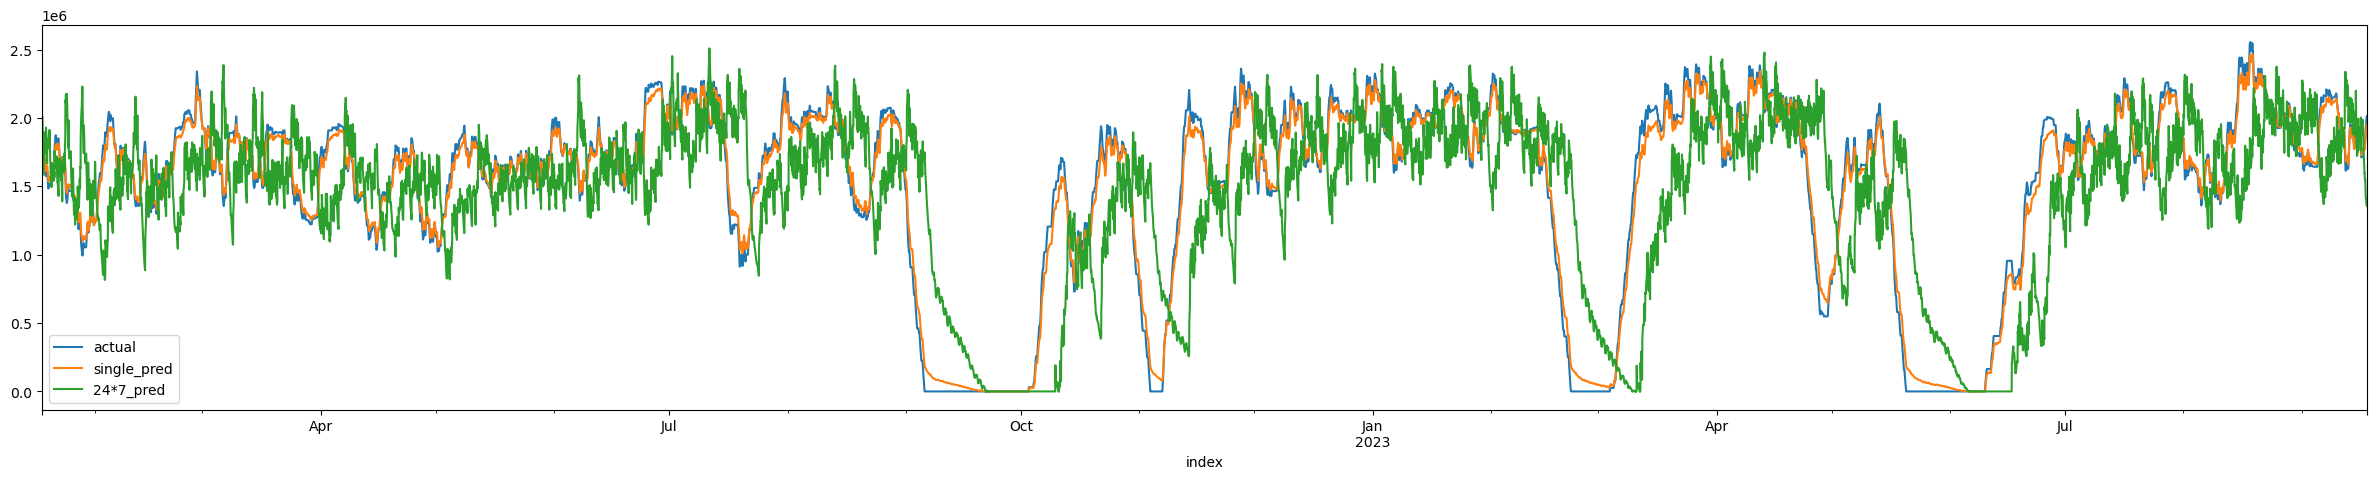

In [42]:
multi_agg_df.plot(figsize=(30,5))

In [112]:
def simulate_lag(lag, multi_agg_df):
    lag_df = multi_agg_df['24*7_pred'][lag:].reset_index().drop('index', axis=1)
    lag_df = pd.concat([lag_df,pd.DataFrame({'24*7_pred':[np.NaN] * lag})]).reset_index().drop('index', axis=1)
    lag_df = lag_df.rename({'24*7_pred':'lag_pred'}, axis=1)
    lag_df.index = multi_agg_df.index
    return pd.concat([multi_agg_df, lag_df], axis=1)

lagr2: 0.8654399435259836


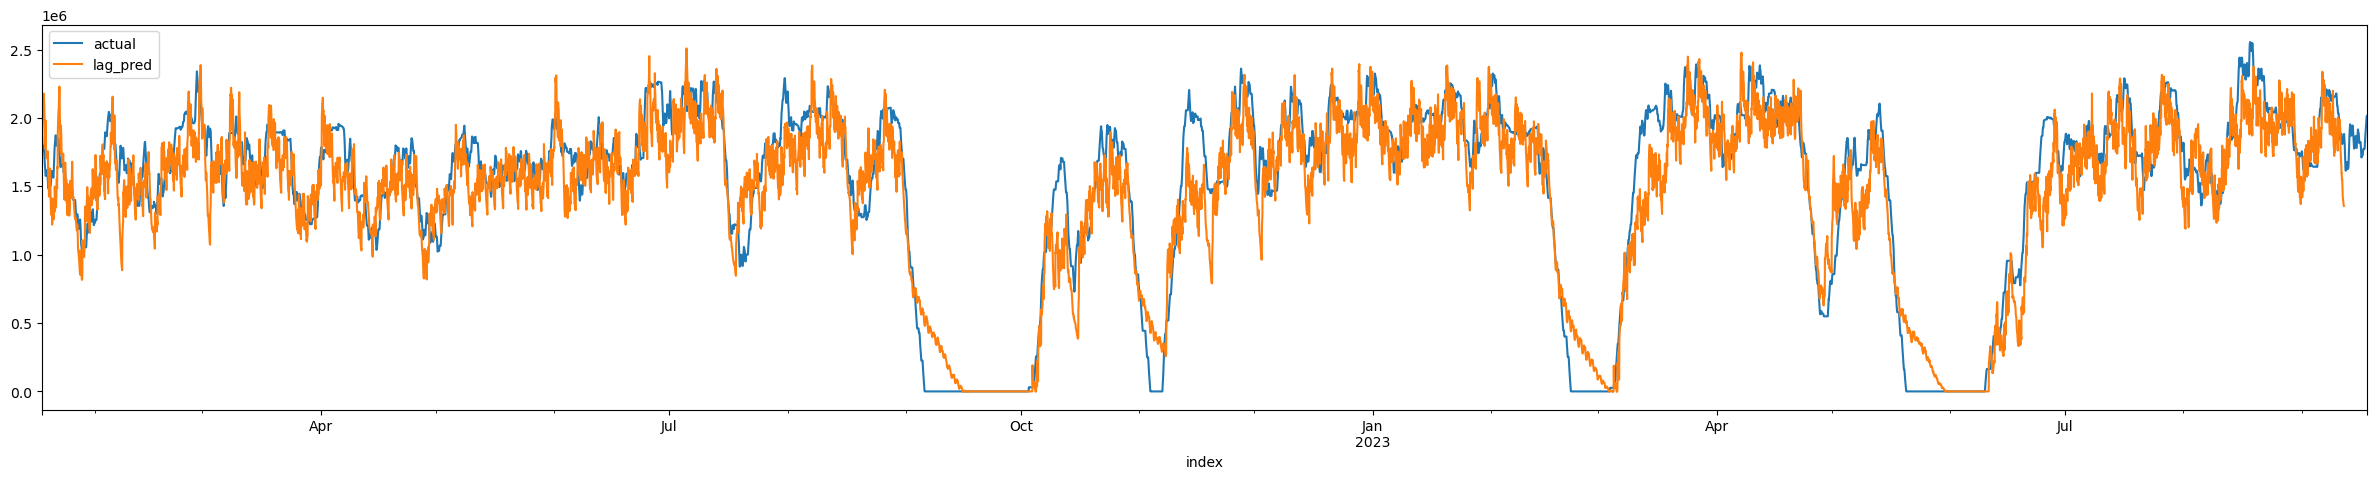

In [128]:
lag_version = simulate_lag(24*6, multi_agg_df)
lag_version[['actual', 'lag_pred']].plot(figsize=(30,5))
lag = lag_version.dropna()[['actual', 'lag_pred']]
print('lagr2:', r2_score(lag['actual'], lag['lag_pred']))

# Save/Load Model

In [142]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

Directory to save the model: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\
Model Name: AutoRegressive


In [143]:
load_mod = torch.load(directory + filename + '.pt')
load_mod.eval()

Linear(in_features=408, out_features=1, bias=True)